# Likelihood (MLE와 MAP)

머신러닝 모델의 역할은 무엇일까요? 우리에게는 데이터 집합이 있고, 데이터가 따르는 확률 분포를 알고싶어합니다. 데이터의 분포를 안다면 새로운 입력값이 들어와도 적절한 출력 값을 추정할 수 있을테니까요.

하지만 데이터셋의 크기는 유한하기 때문에 데이터가 따르는 정확한 확률 분포를 구하는 것은 불가능합니다. 그래서 **파라미터**(parameter, 매개변수)에 의해 결정되는 머신러닝 모델을 만든 다음, 파라미터 값을 조절함으로써 데이터의 분포를 간접적으로 표현합니다.

모델이 표현하는 **확률 분포를 데이터의 실제 분포에 가깝게 만드는 최적의 파라미터 값을 찾는 것**이 머신러닝의 목표라고 할 수 있습니다.

**context**

1. 들어가며: 머신러닝의 목표
2. 확률 변수로서의 모델 파라미터
3. posterior와 prior, likelihood 사이의 관계
4. likelihood와 머신러닝
5. likelihood 감 잡기
6. MLE: 최대 가능도 추론
7. MLE 최적해 구하기
8. MAP: 최대 사후 확률 추정
9. MLE와 MAP의 비교

## 확률 변수로서의 모델 파라미터

간단한 예시로 일차함수 모델을 생각해봅시다.

$$y=ax+b\hspace{10mm}a, b \in \mathbb{R}$$

위 식에서 $a, b$는 모델의 형태를 결정하는 파라미터로 작용ㅇ합니다. $a$와 $b$의 값을 요리조리 바꾸면서 모델을 변형시킬 수 있다는 것입니다.

$\mathbb{R}^2$ 공간 안의 모든 점 $(a, b)$에 대해 일차함수 $y = ax + b$는 유일하게 결정됩니다. (다시 말해서, $\mathbb{R}^2$ 공간 안의 모든 점들은 일차함수들로 이루어진 함수 공간 (function space)의 서로 다른 원소들에 각각 대응됩니다.)

$(a, b)$가 위치하는 $\mathbb{R}^2$ 공간을 **파라미터 공간(parameter space)**라고 부르겠습니다.

![Img](https://aiffelstaticprd.blob.core.windows.net/media/images/math02_1-1-edited.max-800x600.png)

아래는 파라미터 공간에서 두 점 $a, b$를 뽑아 $y = ax + b$의 그래프를 그리는 코드입니다. 이론상으로는 실수 집합 전체에서 샘플링을 해야하지만, 코드로 구현하기가 불가능하고 간단한 시각화를 위해 $[-10, 10)$ 구간에서 샘플링했습니다.

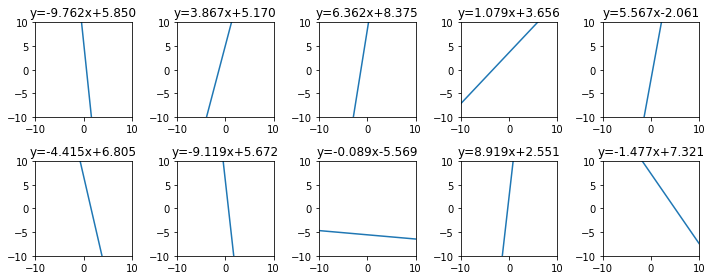

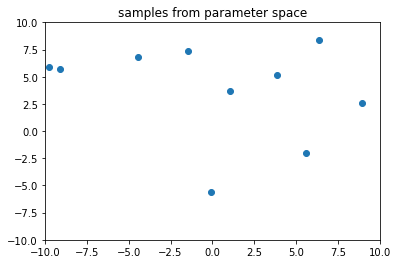

In [1]:
import numpy as np
import matplotlib.pyplot as plt

parameter_points = []
fig1, axes1 = plt.subplots(2, 5, figsize = (10, 4))

for ax in axes1.flatten():
    # np.random.uniform : 정해진 구간에서 수를 무작위로 추출하여 반환
    a, b = np.random.uniform(-10, 10, size = 2)
    a = round(a, 3)
    b = round(b, 3)
    parameter_points.append((a, b))
    
    x = np.linspace(-10, 10, 50)
    y = a * x + b
    ax.plot(x, y)
    
    ax.set_title('y='+str(a)+'x'+'{0:+.03f}'.format(b))
    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)
    
plt.tight_layout()

px, py = np.split(np.array(parameter_points), 2, axis=1)
fig2 = plt.figure()
axes2 = plt.gca()

axes2.set_title('samples from parameter space')
axes2.set_xlim(-10, 10)
axes2.set_ylim(-10, 10)

plt.scatter(px, py)
plt.show()

일차함수 모델의 파라미터 $a, b$를 파라미터 공간 $\mathbb{R}^2$의 원소 $(a, b)$로 본다면, 파라미터 공간에 주어진 확률 분포 역시 생각해볼 수 있습니다.

![img](https://aiffelstaticprd.blob.core.windows.net/media/images/math02_1-2.max-800x600.png)

위 그림에서 파라미터 공간에 주어진 확률 분포는 평균이 $(1, 0)$인 정규분포이므로 $y = ax + b$에서 $a$와 $b$의 값이 각각 1과 0에 가까운 확률, 그러니까 모델이 $y = x$에 가까울 확률이 크다고 보는 것입니다.

왼쪽의 파라미터 공간에서 원소 하나를 뽑은 다음 일차함수의 그래프를 그렸을 때, 모델의 형태가 오른쪽의 진한 초록색 직선들과 비슷할 확률이 클 것이고, 연두색 직선들처럼 기울기나 y절편 차이가 많이 날 확률은 적겠죠.

아래 코드는 평균이 $(1, 0)$이고 표준편차가 0.5인 정규분포에서 10개의 점을 무작위로 뽑은 다음, 대응되는 일차함수의 그래프를 각각 그려주는 코드입니다. 위쪽의 예제와 비교하면 파라미터 공간에서 추출된 샘플들이 $(1, 0)$ 주위에 모여있고, 결과 그래프들의 차이가 작은 것을 확인할 수 있습니다.

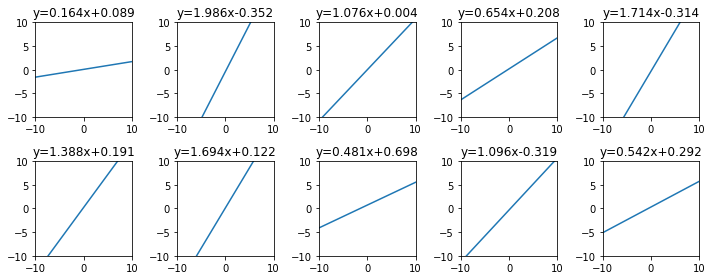

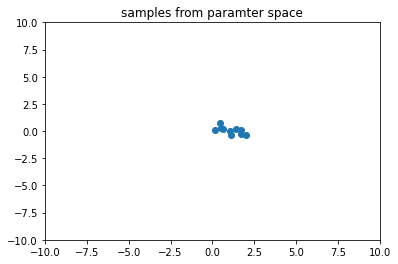

In [4]:
parameter_points = []
fig, axes1 = plt.subplots(2, 5, figsize = (10, 4))

for ax in axes1.flatten():
    a, b = np.random.normal(loc = [1, 0], scale = 0.5)
    a = round(a, 3)
    b = round(b, 3)
    parameter_points.append((a, b))
    
    x = np.linspace(-10, 10, 50)
    y = a * x + b
    ax.plot(x, y)
    
    ax.set_title('y='+str(a)+'x'+'{0:+.03f}'.format(b))
    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)
    
plt.tight_layout()

px, py = np.split(np.array(parameter_points), 2, axis=1)
fig2 = plt.figure()
axes2 = plt.gca()

axes2.set_title('samples from paramter space')
axes2.set_xlim(-10, 10)
axes2.set_ylim(-10, 10)

plt.scatter(px, py)
plt.show()

## posterior와 prior, likelihood의 사이의 관계

베이지안 머신러닝 모델은 데이터를 통해 파라미터 공간의 확률 분포를 학습합니다. 

모델 파라미터를 고정된 값이 아닌 불확실성(uncertainty)을 가진 확률 변수로 보는 것, 데이터를 관찰하면서 업데이트 되는 값으로 보는 것은 베이지안 머신러닝의 핵심 아이디어입니다.

### 사전확률, 가능도, 사후확률 (prior, likelihood, posterior)

이제 데이터의 집합 $X$가 주어졌습니다. 그러면 데이터가 따르는 어떤 확률 분포 $p(X)$가 있겠죠. 

우리의 목표는 $p(X)$를 가장 잘 나타내는 일차함수 모델 $y = ax + b = \theta^T x$를 찾는 것입니다.

$$\mathbf{\theta}=
\begin{bmatrix}
a \ b
\end{bmatrix},\hspace{5mm}
\mathbf{x}=
\begin{bmatrix}
x \ 1
\end{bmatrix}$$

데이터를 관찰하기 전 파라미터 공간에 주어진 확룰 분포 $p(\theta)$를 **prior**(prior probability, **사전 확률**)이라고 합니다. 이전 스텝의 예제에서는 평균이 $(1, 0)$이고 표준편차가 0.5인 정규분포였습니다. prior는 일반적인 정규분포가 될 수도 있고, 데이터의 특성이 반영된 특정 확률 분포가 될 수도 있습니다.

만약 prior 분포를 고정시킨다면, 주어진 파라미터 분포에 대해서 우리가 갖고 있는 데이터가 얼마나 '그럴듯한지' 계산할 수 있습니다. 이것을 나타내는 값이 **likelihood**(**가능도**, 우도)입니다.

식으로 나타내면,

$$p(X = x|\theta)$$

즉, 파라미터의 분포 $p(\theta)$가 정해졌을 때 $x$라는 데이터가 관찰될 확률입니다.

likelihood가 $\theta$에 의해 결정되는 함수라는 것을 강조하기 위해서 가능도 함수를 $\mathcal{L}(\mathbf{\theta}|x)$라고 표기하기도 합니다.

결국 우리가 구하고 싶은 것은 모델의 파라미터 $\theta$값이고, 데이터는 이미 알고 있는 고정된 값이니까요.

likelihood가 높다는 것은 곧 우리가 지정한 파라미터 조건에서 데이터가 관찰될 확률이 높다는 것이고, 데이터의 분포를 모델이 잘 표현하는 것이라고 생각할 수 있습니다. 이렇게 데이터들의 likelihood 값을 최대화하는 방향으로 모델을 학습시키는 방법을 **최대 가능도 추정**(maximum likelihood estimation, **MLE**)라고 합니다.

반대로, 데이터 집합 $X$가 주어졌을 때 파라미터 $\theta$의 분포 $p(\theta|X)$를 생각해볼 수 있습니다. 이 값을 '데이터를 관찰한 후 계산되는 확률'이라는 뜻에서 **posterior**(posterior probability, **사후 확률**)이라고 부릅니다.

생각해보면 이게 우리에게 필요한 값인데, 앞에서 얘기했듯이 데이터 포인트의 개수는 유한하기 때문에 데이터가 따르는 확률 분포 $p(X)$는 우리가 정확하게 알 수 없습니다.

애초에 머신러닝의 목표가 $p(X)$를 직접 구할 수가 없으니까 모델 파라미터 $\theta$를 조절해가며 간접적으로 근사하는 것이었죠.

그래서 posterior를 직접 계산해서 최적의 $\theta$값을 찾는 것이 아니라, prior와 likelihood에 관한 식으로 변형한 다음 그 식을 최대화하는 파라미터 $\theta$를 찾습니다.

이렇게 posterior를 최대화하는 방향으로 모델을 학습시키는 방법을 **최대 사후 확률 추정**(maximum a posterior estimation, **MAP**)이라고 합니다. MLE와 MAP에 대해서는 뒤에서 더 자세하게 다루도록 하겠습니다.

### posterior와 prior, likelihood 사이의 관계

확률의 곱셈 정리에 의해 확률 변수 $X$와 $\theta$의 joint probability $p(X, \theta)$는 다음과 같이 나타낼 수 있습니다.

$$p(X,\mathbf{\theta})=p(\mathbf{\theta}|X)p(X)=p(X|\mathbf{\theta})p(\mathbf{\theta})$$

양변을 $p(X)$로 나누어주면 앞에서 공부했던 베이즈 정리와 같은 식이 나옵니다.

$$p(\mathbf{\theta}|X)=\frac{p(X|\mathbf{\theta})p(\mathbf{\theta})}{p(X)}$$

$$\left(\textrm{posterior}=\frac{\textrm{likelihood} \times \textrm{prior}}{\textrm{evidence}},\hspace{10mm}\textrm{posterior}\propto\textrm{likelihood} \times \textrm{prior}\right)$$

데이터가 따르는 정확한 확률분포 $p(X)$를 알 수 없어서, posterior $p(\theta | X)$의 값도 직접 구할 수 없다는 이야기를 했습니다. 우변의 식에서도 $p(X)$로 나누는 부분이 있기 때문에 이 식으로도 값을 계산할수는 없습니다. 

다만 여기에서 $p(X)$는 고정된 값이고 (데이터가 바뀌지 않으니) likelihood와 prior는 계산이 가능하기 때문에 우변을 최대화하는 파라미터의 값은 구할 수 있는 것입니다.

## Likelihood와 머신러닝

머신러닝 모델은 언제까지나 한정된 파라미터로 데이터의 실제 분포를 근사하는 역할을 하기 때문에 어떤 데이터가 들어와도 100%의 정확도를 내는 모델을 만들기는 불가능합니다. 그래서 모델이 입력 데이터로부터 예측한 출력 데이터(prediction)와 우리가 알고있는 데이터의 실제 값(label) 사이에는 오차가 생기게 되는데, 우리에게 관찰되는 데이터에는 이미 노이즈가 섞여있어서 이런 오차가 발생한다고 해석합니다.

![img](https://aiffelstaticprd.blob.core.windows.net/media/original_images/math02_2-1-edited.png)

머신러닝에서 지도학습(supervised learning)을 생각해봅시다. 데이터셋은 입력데이터 $x$와 라벨 $y$가 짝지어진 $\{(\mathbf{x}_1, y_1), (\mathbf{x}_2, y_2), \dots, (\mathbf{x}_n, y_n)\}$ 형태입니다. 이 데이터셋을 선형 모델 $y = \theta^T x$로 표현한다고 하면, $x_n$이라는 입력 데이터가 들어왔을 때 모델이 예측한 값은 $\theta^Tx_n$이 되겠죠. 이 값과 데이터의 라벨 $y_n$의 차이를 노이즈로 보는 것입니다.

앞에서 likelihood는 파라미터 분포가 주어졌을 때 특정 데이터가 관찰될 확률 $p(X=x|\theta)$를 나타낸다고 이야기했습니다. 지도 학습의 예시에서는, 파라미터 분포 $\theta$와 입력 데이터 $x_n$이 주어졌을 때 라벨 $y_n$을 예측하는 문제가 됩니다. 입력 데이터의 집합을 $X$, 라벨들의 집합을 $Y$라고 할 때, likelihood는 파라미터와 입력 데이터가 주어졌을 때 출력값(라벨)의 확률 분포, 즉 $p(Y|\theta, X)$가 됩니다.

일단 데이터셋 전체의 likelihood 대신 하나의 likelihood $p(y_n|\theta, x_n)$을 생각해봅시다. <br/>
출력값의 분포를 어떻게 생각할 수 있을까요? 모델을 선형 모델 $y=\theta^T x$로 잡았을 때, 출력값의 분포는 모델의 예측값 $\theta^T x_n$에다가 노이즈의 분포를 더한 값이 될겁니다. <br/>
노이즈 분포를 평균이 0이고 표준편차가 $\sigma$인 정규분포로 가정한다면, 출력값의 분포는 평균이 $\theta^Tx_n$이고 표준편차가 $\sigma$인 정규분포가 됩니다. 

$$p(y_n|\mathbf{\theta}, \mathbf{x}_n) = \mathcal{N}(y_n|\mathbf{\theta}^\top\mathbf{x}_n, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left({-\frac{(y_n-\mathbf{\theta}^\top\mathbf{x}_n)^2}{2\sigma^2}}\right)$$



## Likelihood 감잡기

이제 코드를 실행시켜보면서 likelihood가 어떤 값인지 감을 잡아보도록 할까요?

아래는 5개의 랜덤한 데이터 포인트를 생성하고 좌표평면 위에 표시해주는 코드입니다.

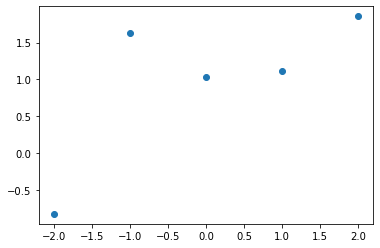

In [5]:
import math
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(321)

input_data = np.linspace(-2, 2, 5)
label = input_data + 1 + np.random.normal(0, 1, size=5)

plt.scatter(input_data, label)
plt.show()

아래 코드에서 일차함수 모델의 식을 바꾸어가며 데이터 포인트 5개의 likelihood값이 각각 어떻게 바뀌는지 살펴봅시다.

노이즈 분포의 표준편차는 데이터의 실제 분포와 관련된 값이라 우리가 알 수 없지만, 다음 스텝에서 공부할 MLE를 사용하면 표준편차를 알지 못해도 최적의 파라미터 값을 찾을 수 있습니다. 예제에서는 계산을 위해 표준편차를 0.1로 잡았습니다.

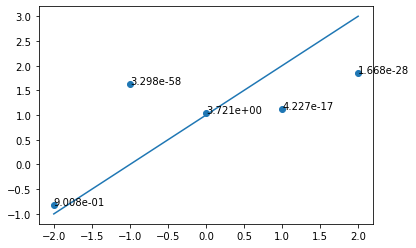

In [6]:
# model : y = ax + b
# a, b 값을 바꾸면서 실행해보세요.
# ------------ #
a = 1
b = 1
# ------------ #

# 모델 예측값
model_output = a * input_data + b
likelihood = []

# x : 입력 데이터, y : 데이터 라벨
# 예측값과 라벨의 차이를 제곱헤 exp에 사용
for x, y, output in zip(input_data, label, model_output):
    likelihood.append(1/(math.sqrt(2*math.pi*0.1*0.1))*math.exp(-pow(y-output, 2)/(2*0.1*0.1)))

model_x = np.linspace(-2, 2, 50)
model_y = a * model_x + b

fig, ax = plt.subplots()
ax.scatter(input_data, label)
ax.plot(model_x, model_y)

for i, text in enumerate(likelihood):
    ax.annotate("%.3e"% text, (input_data[i], label[i]))

plt.show()

데이터 포인트 옆에 있는 숫자는 likelihood의 값이고 직선은 모델이 표현하는 함수의 그래프입니다.

a, b의 값을 한번 바꿔봅시다!

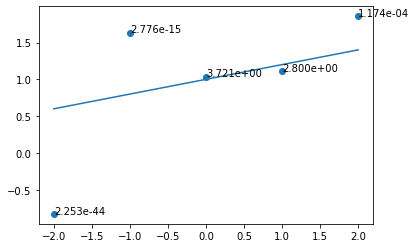

In [7]:
# model : y = ax + b
# a, b 값을 바꾸면서 실행해보세요.
# ------------ #
a = 0.2
b = 1
# ------------ #

# 모델 예측값
model_output = a * input_data + b
likelihood = []

# x : 입력 데이터, y : 데이터 라벨
# 예측값과 라벨의 차이를 제곱헤 exp에 사용
for x, y, output in zip(input_data, label, model_output):
    likelihood.append(1/(math.sqrt(2*math.pi*0.1*0.1))*math.exp(-pow(y-output, 2)/(2*0.1*0.1)))

model_x = np.linspace(-2, 2, 50)
model_y = a * model_x + b

fig, ax = plt.subplots()
ax.scatter(input_data, label)
ax.plot(model_x, model_y)

for i, text in enumerate(likelihood):
    ax.annotate("%.3e"% text, (input_data[i], label[i]))

plt.show()

### Likelihood가 왜 중요할까?

위 예제에서 볼 수 있듯이, 데이터 포인트가 모델 함수에서 멀어질수록 데이터의 likelihood는 기하급수적으로 감소합니다. likelihood를 구하는 식을 보면 모델 예측값과 데이터 라벨의 차이를 제곱해서 exponential 위에 올려놓은 것을 확인할 수 있습니다. 예측값과 라벨의 차이가 조금만 벌어져도 likelihood 값은 민감하게 반응하겠죠.

머신러닝의 목표가 데이터 포인트들을 최대한 잘 표현하는 모델을 찾는 것이었다는 사실을 생각하면, 결국 데이터 포인트들의 likelihood 값을 크게 하는 모델을 찾는 것이 됩니다.

데이터의 likelihood 값을 최대화하는 모델 파라미터를 찾는 방법이 **최대 가능도 추론**(maximum likelihood estimation, **MLE**)입니다. MLE에 대해서 좀 더 자세하게 알아봅시다!

## MLE : 최대 가능도 추론

### 데이터셋 전체의 likelihood

앞 스텝에서 데이터 포인트 하나의 likelihood 식을 살펴보았습니다. 모델 파라미터 $\theta$가 주어졌을 때, 데이터 포인트 $(x_n, y_n)$의 likelihood는 다음과 같습니다.

$$p(y_n|\mathbf{\theta}, \mathbf{x}_n) = \mathcal{N}(y_n|\mathbf{\theta}^\top\mathbf{x}_n, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left({-\frac{(y_n-\mathbf{\theta}^\top\mathbf{x}_n)^2}{2\sigma^2}}\right)$$

좋은 머신러닝 모델은 하나의 데이터에 대해서만 likelihood가 큰 모델이 아니라 데이터셋에 있는 모든 데이터 포인트의 likelihood 값을 크게 만드는 모델입니다. 데이터셋 전체의 likelihood는 어떻게 계산하면 좋을까요?

우리가 가지고 있는 데이터 포인트 $(\mathbf{x}_1, y_1), \dots, (\mathbf{x}_n, y_n)$은 **서로 독립**이고 (independent) **같은 확률 분포를 따른다**고 (identically distributed) 가정합니다. <br/>
이 조건을 *independent and identically distributed*, 줄여서 *i.i.d*라고 부르는데 머신러닝 문제에서 꼭 필요한 전제조건입니다. 데이터 포인트들이 서로 독립이므로, 데이터셋 전체의 likelihood $p(Y|\theta, X)$는 데이터 포인트 각각의 likelihood를 모두 곱한 값과 같습니다.

$$p(Y|\mathbf{\theta}, X) = \prod_n p(y_n|\mathbf{\theta}, \mathbf{x}_n)$$

MLE를 실제로 적용할 때는 likelihood 대신 log likelihood를 최대화하는 파라미터를 구합니다. 데이터셋의 Likelihood가 데이터 포인트 각각의 likelihood를 곱한 형태인데, 로그를 씌우면 곱셈 연산이 덧셈 연산으로 바뀌면서 미분 계산이 편리해집니다. <br/>
또한 로그 함수는 단조 증가(monotonically increasing)하므로 Likelihood를 최대화하는 파라미터와 lod likelihood를 최대화하는 파라미터 값이 같아서 학습 결과에 영향을 주지 않습니다. <br/>
구현 측면에서 보면, 앞의 예제에서 보셨듯이 likelihood 값은 0에 가까운 수로 많이 계산됩니다. 이 수들을 곱하다보면 CPU가 계산할 수 있는 범위를 넘어서는 언더플로우가 발생할 가능성이 있습니다. likelihood 값에 로그를 씌우면 이런 문제를 예방할 수 있습니다.

likelihood 계산식에 로그를 씌우면 아래와 같은 결과가 나옵니다.

$$\log p(Y|\mathbf{\theta}, X) = \log \prod_n p(y_n|\mathbf{\theta}, \mathbf{x}_n) = \sum_n \log p(y_n|\mathbf{\theta}, \mathbf{x}_n)$$

$$=\sum_n \log \left(\frac{1}{\sqrt{2\pi\sigma^2}} \exp \left(-\frac{(y_n-\mathbf{\theta}^\top\mathbf{x}_n)^2}{2\sigma^2}\right)\right)$$

$$=\sum_n \log \frac{1}{\sqrt{2\pi\sigma^2}} + \sum_n \log \exp \left(-\frac{(y_n-\mathbf{\theta}^\top\mathbf{x}_n)^2}{2\sigma^2}\right)
$$

$$=\sum_n \log \frac{1}{\sqrt{2\pi\sigma^2}} + \sum_n \left(-\frac{(y_n-\mathbf{\theta}^\top\mathbf{x}_n)^2}{2\sigma^2}\right)$$

$$=\textrm{constant} + \frac{1}{2\sigma^2}\sum_n (-(y_n-\mathbf{\theta}^\top\mathbf{x}_n)^2)$$

likelihood를 최대화하는 파라미터를 $\theta_{ML}$(ML : maximum likelihood)라고 하면,

$$\mathbf{\theta}_{ML} = \arg\max_\mathbf{\theta} \log p(Y|\mathbf{\theta}, X) = \arg\max_\mathbf{\theta} \left(\frac{1}{2\sigma^2}\sum_n (-(y_n-\mathbf{\theta}^\top\mathbf{x}_n)^2) + \textrm{constant}\right)$$

$\theta$와 관계없는 부분을 빼고 식을 정리하면 다음과 같습니다. 손실 함수를 최소화하는 관점에서, log likelihood를 최대화하는 대신 negative lod likelihood $(-\log p(Y|\mathbf{\theta}, X))$ 를 최솧화하는 식으로 나타내기도 합니다.

$$\mathbf{\theta}_{ML} = \arg\min_\mathbf{\theta} \frac{1}{2\sigma^2} \sum_n (y_n-\mathbf{\theta}^\top\mathbf{x}_n)^2$$

최소제곱법 (least square)의 식과 같은 것을 확인할 수 있습니다. <br/>
최소제곱법은 선형 모델에서 노이즈의 분포가 $\mathcal{N}(0,\sigma^2)$라고 가정할 때 negative log likelihood를 최소화하는 파라미터 값을 찾는 것과 본질적으로 같습니다.

우리가 최소화해야할 식을 $\theta$에 대한 함수 $\mathcal{L}(\mathbf{\theta})$로 놓으면

$$\mathcal{L}(\mathbf{\theta}) = \frac{1}{2\sigma^2} \sum_n (y_n-\mathbf{\theta}^\top\mathbf{x}_n)^2$$

$\mathcal{L}(\mathbf{\theta})$를 최소화하는 $\theta$의 값은 $\mathcal{L}(\mathbf{\theta})$를 $\theta$에 대해 미분한 식을 0으로 만드는 $\theta$의 값과 같습니다.

물론 일반적으로는 도함수의 부호 변화나 local minimum 여부 등을 모두 따져야 하지만, $\mathcal{L}(\mathbf{\theta})$는 $\theta$에 대한 2차식이므로 유일한 최솟값을 가집니다. 따라서 도함수를 0으로 만드는 $\theta$값을 찾는 것으로도 충분합니다.

$$\begin{split}
\frac{\mathrm{d}\mathcal{L}}{\mathrm{d}\mathbf{\theta}} & = \frac{\mathrm{d}}{\mathrm{d}\mathbf{\theta}} \left(\frac{1}{2\sigma^2} \sum_n (y_n-\mathbf{\theta}^\top\mathbf{x}_n)^2\right) = \frac{\mathrm{d}}{\mathrm{d}\mathbf{\theta}} \left(\frac{1}{2\sigma^2} \sum_n (y_n-\mathbf{x}_n^\top\mathbf{\theta})^2\right) \\
& \underset{(1)}{=} \frac{1}{2\sigma^2} \frac{\mathrm{d}}{\mathrm{d}\mathbf{\theta}} (\mathbf{y}-X\mathbf{\theta})^\top(\mathbf{y}-X\mathbf{\theta}) \\
& = \frac{1}{2\sigma^2} \frac{\mathrm{d}}{\mathrm{d}\mathbf{\theta}} (\mathbf{y}^\top\mathbf{y}-\mathbf{y}^\top X\mathbf{\theta}-\mathbf{\theta}^\top X^\top\mathbf{y}+\mathbf{\theta}^\top X^\top X\mathbf{\theta}) \\
& \underset{(2)}{=} \frac{1}{2\sigma^2} \frac{\mathrm{d}}{\mathrm{d}\mathbf{\theta}} (\mathbf{y}^\top\mathbf{y}-2\mathbf{y}^\top X\mathbf{\theta}+\mathbf{\theta}^\top X^\top X\mathbf{\theta})\\
& \underset{(3)}{=} \frac{1}{\sigma^2} \left(-\mathbf{y}^\top X+\mathbf{\theta}^\top X^\top X \right)
\end{split}$$

데이터셋 $X=[\mathbf{x}_1 \mathbf{x}_2 \dots \mathbf{x}_n]^\top \in \mathbb{R}^{n \times d}$ (d차원 데이터 $\mathbf{x}_n=[x_{n1} \dots x_{nd}]^\top$), 라벨 $\mathbf{y}=[y_1 y_2 \dots y_n]^\top$일 때, 최적 파라미터 $\theta_{ML}$은 다음과 같습니다.

$$\mathbf{\theta}_{ML} = (X^\top X)^{-1}X^\top\mathbf{y}$$

## MLE 최적해 구하기

### 데이터셋 생성

MLE를 이용해 최적의 파라미터를 찾아보고 데이터셋의 likelihood도 계산해보도록 하겠습니다. 아래 코드는 $ y = x + 1 $ 함수를 기준으로 랜덤한 노이즈를 섞어서 데이터 포인트 20개를 생성하고 시각화하는 코드입니다. 데이터 생성 단계에서 지정한 노이즈 분포는 평균이 0이고 표준 편차가 0.5인 정규분포입니다. 

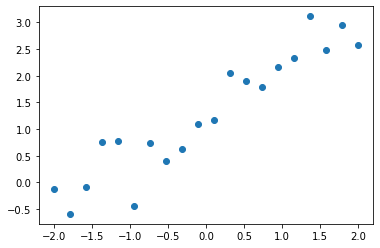

In [8]:
import math
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)
num_samples = 20

input_data = np.linspace(-2, 2, num_samples)
labels = input_data + 1 + np.random.normal(0, 0.5, size=num_samples)

plt.scatter(input_data, labels)
plt.show()

### likelihood와 파라미터 계산

데이터를 생성할때는 노이즈 분포의 표준편차를 0.5로 정했지만 데이터를 관찰하고 모델을 설계하는 입장에서는 노이즈의 원래 표준편차를 알 수 없습니다. 노이즈의 표준편차를 0.1로 가정했다고 합시다. likelihood와 negative log likelihood는 다음과 같이 계산됩니다.

$$p(Y|\mathbf{\theta}, X) = \prod_n \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left({-\frac{(y_n-\mathbf{\theta}^\top\mathbf{x}_n)^2}{2\sigma^2}}\right)$$

$$-\log p(Y|\mathbf{\theta}, X) = -\left(\sum_n \log \frac{1}{\sqrt{2\pi\sigma^2}} + \frac{1}{2\sigma^2}\sum_n (-(y_n-\mathbf{\theta}^\top\mathbf{x}_n)^2)\right)$$

구현에서 주의해야 할 부분은, 입력 데이터가 실수 스칼라 값을 갖는 것처럼 보이지만 실제로는 변수 $x와 상수항이 묶인 2차원 벡터로 표현된다는 것입니다. 그래서 데이터 포인트들의 묶음 $X$는 크기가 $20×2$인 행렬입니다.

$$X = \begin{bmatrix}
\mathbf{x}_1 \\ \mathbf{x}_2 \\ \vdots \\ \mathbf{x}_{20}
\end{bmatrix}
= \begin{bmatrix}
x_1 & 1\\ x_2 & 1\\ \vdots & \vdots \\ x_{20} & 1
\end{bmatrix}$$

MLE의 최적 파라미터 $\theta_{ML}$은 다음과 같이 계산됩니다.

$$\mathbf{\theta}_{ML} = (X^\top X)^{-1}X^\top\mathbf{y}$$

아래 코드로 구한 최적의 모델은 $y=0.8578x+1.2847$입니다. 데이터 포인트들이 $ y = x + 1 $ 함수로부터 생성된 것을 생각하면 꽤 가까운 결과가 나왔습니다.


In [9]:
def likelihood(labels, preds):
    result = 1/(np.sqrt(2*math.pi*0.1*0.1))*np.exp(-np.power(labels-preds,2)/(2*0.1*0.1))
    
    return np.prod(result)

def neg_log_likelihood(labels, preds):
    const_term = len(labels)*math.log(1/math.sqrt(2*math.pi*0.1*0.1))

    return (-1)*(const_term + 1/(2*0.1*0.1)*np.sum(-np.power(labels-preds,2)))

slope: 0.8578 bias: 1.2847
likelihood: 2.9724e-54
negative log likelihood: 1.2325e+02


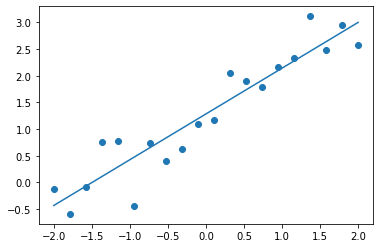

In [10]:
# X: 20x2 matrix, y: 20x1 matrix
# input_data 리스트를 column vector로 바꾼 다음 np.append 함수로 상수항을 추가합니다.
X = np.append(input_data.reshape((-1, 1)), np.ones((num_samples, 1)), axis=1)
y = labels

theta_1, theta_0 = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), y)

print('slope: '+'%.4f'%theta_1+' bias: '+'%.4f'%theta_0)

predictions = theta_1 * input_data + theta_0
print('likelihood: '+'%.4e'%likelihood(labels, predictions))
print('negative log likelihood: '+'%.4e'%neg_log_likelihood(labels, predictions))

model_x = np.linspace(-2, 2, 50)
model_y = theta_1 * model_x + theta_0

plt.scatter(input_data, labels)
plt.plot(model_x, model_y)
plt.show()

## MAP : 최대 사후 확률 추정

### prior 분포의 등장

선형 회귀 문제에서 MLE로 구한 최적 파라미터 식을 다시 살펴봅시다.

$$\mathbf{\theta}_{ML} = (X^\top X)^{-1}X^\top\mathbf{y}$$

$X$는 데이터셋 행렬이고, $y$는 라벨들을 모아놓은 벡터였죠. 이 식에서 알 수 있는 것은, **MLE의 최적해는 오로지 관측된 데이터 값에만 의존한다**는 사실입니다.

물론 이런 접근법은 계산이 비교적 간단하다는 장점이 있지만, 관측된 데이터에 노이즈가 많이 섞여있는 경우, 이상치(outlier) 데이터가 존재하는 경우에는 모델의 안정성이 떨어진다는 단점도 있습니다.

앞에서 머신러닝 모델의 최적 파라미터를 찾는 방법에는 두가지가 있다고 했습니다. 

1. 하나는 likelihood를 최대화하는 MLE였고
2. 다른 하나는 이번에 다룰 **최대 사후확률 추정**(maximum a posteriori estimation, **MAP**)입니다.

### MAP

MAP는 데이터셋이 주어졌을 때 파라미터의 분포, 즉 $p(\theta | X)$에서 확률 값을 최대화하는 파라미터 $\theta$를 찾습니다. 직관적으로 이야기하면 '이런 데이터가 있을 때 파라미터의 값이 무엇일 확률이 제일 높은가?'의 문제겠죠.

지도 학습의 경우 posterior는 $p(\theta | X, Y)$로 나타낼 수 있습니다. 이 식을 prior $p(\theta)$와 likelihood $p(Y|\theta, X)$에 관한 식으로 변형하면 다음과 같습니다.

$$\begin{split}
p(\mathbf{\theta}|X,Y) & =\frac{p(\mathbf{\theta},X,Y)}{p(X,Y)} \\
& = \frac{p(X,Y|\mathbf{\theta})p(\mathbf{\theta})}{p(X,Y)} \\
& = \frac{p(Y|\mathbf{\theta},X)p(\mathbf{\theta})}{p(Y|X)}
\end{split}$$

prior 분포 $p(\theta)$는 관찰된 데이터가 없을 때 파라미터 공간에 주어진 확률분포입니다. $p(\theta = \theta_0)$ 값을 크게 만드는 파라미터 $\theta_0$을 '그럴듯한' 파라미터로 생각하는 것입니다.

여기에서는 $p(\theta)$를 평균이 $(0, 0)$이고 공분산 $\Sigma=\alpha^2\mathbf{I}$인 정규분포로 정의하겠습니다. ($\Sigma=\alpha^2\mathbf{I}$ 이므로 $|\Sigma|=\alpha^4$, $\Sigma^{-1}=(1/\alpha^2)\mathbf{I}$)

$$\begin{split}
p(\mathbf{\theta})=\mathcal{N}(\mathbf{0}, \alpha^2\mathbf{I}) & = \frac{1}{\sqrt{(2\pi)^2|\Sigma|}}\exp\left(-\frac{1}{2}(\mathbf{\theta}-\mathbf{0})^\top \Sigma^{-1}(\mathbf{\theta}-\mathbf{0})\right) \\
& = \frac{1}{2\pi\alpha^2}\exp\left(-\frac{1}{2\alpha^2}\mathbf{\theta}^\top \mathbf{\theta}\right)
\end{split}$$

MLE에서 negative log likelihood를 최소화했던 것과 같이, MAP에서도 실제로는 posterior를 최대화하는 파라미터 대신 negative log posterior를 최소화하는 파라미터 값을 구합니다. 

$$\begin{split}
\arg\min_{\mathbf{\theta}}(-\log p(\mathbf{\theta}|X,Y)) & = \arg\min_{\mathbf{\theta}}\left(-\log \frac{p(Y|\mathbf{\theta},X)p(\mathbf{\theta})}{p(Y|X)}\right) \\
& = \arg\min_{\mathbf{\theta}}(-\log p(Y|\mathbf{\theta},X)-\log p(\mathbf{\theta})+\log p(Y|X))
\end{split}$$

$\log p(Y|X)$ 부분은 $\theta$에 의한 식이 아니므로 제외하면

$$\arg\min_{\mathbf{\theta}}(-\log p(\mathbf{\theta}|X,Y))=\arg\min_{\mathbf{\theta}}(-\log p(Y|\mathbf{\theta},X)-\log p(\mathbf{\theta}))$$

우리가 최소화해야할 posterior 함수를 편의상 $p(\theta)$로 놓겠습니다. (일반적인 notation은 아닙니다)

$$\begin{split}
\mathcal{P}(\mathbf{\theta}) & =-\log p(Y|\mathbf{\theta},X)-\log p(\mathbf{\theta}) \\
& = -\left(\textrm{constant} + \frac{1}{2\sigma^2}\sum_n (-(y_n-\mathbf{\theta}^\top\mathbf{x}_n)^2)\right) - \left(\textrm{constant}-\frac{1}{2\alpha^2}\mathbf{\theta}^\top \mathbf{\theta}\right) \\
& = \frac{1}{2\sigma^2}\sum_n (y_n-\mathbf{\theta}^\top\mathbf{x}_n)^2+\frac{1}{2\alpha^2}\mathbf{\theta}^\top \mathbf{\theta}+\textrm{constant}
\end{split}$$

MLE에서 $\mathcal{L}(\mathbf{\theta})$를 최소화하는 $\theta$를 찾기 위해 미분한 식을 0으로 만드는 $\theta$를 계산했던 것처럼, MAP에서 $p(\theta)$를 최소화하는 $\theta$를 찾는 방법도 똑같습니다.

$$\begin{split}
\frac{\mathrm{d}\mathcal{P}}{\mathrm{d}\mathbf{\theta}} & = \frac{\mathrm{d}}{\mathrm{d}\mathbf{\theta}}(-\log p(Y|\mathbf{\theta},X)-\log p(\mathbf{\theta})) \\
& = \frac{\mathrm{d}}{\mathrm{d}\mathbf{\theta}}\left(\frac{1}{2\sigma^2}\sum_n (y_n-\mathbf{\theta}^\top\mathbf{x}_n)^2\right)+\frac{\mathrm{d}}{\mathrm{d}\mathbf{\theta}}\left(\frac{1}{2\alpha^2}\mathbf{\theta}^\top \mathbf{\theta}\right) \\
& = \frac{1}{\sigma^2} \left(-\mathbf{y}^\top X+\mathbf{\theta}^\top X^\top X \right)+\frac{1}{\alpha^2}\mathbf{\theta}^\top
\end{split}$$

위의 식의 값이 $\theta^T$가 되어야 하므로

$$\frac{1}{\sigma^2} \left(-\mathbf{y}^\top X+\mathbf{\theta}^\top X^\top X \right)+\frac{1}{\alpha^2}\mathbf{\theta}^\top=\mathbf{0}^\top \\
\Leftrightarrow \frac{1}{\sigma^2}\mathbf{\theta}^\top X^\top X+\frac{1}{\alpha^2}\mathbf{\theta}^\top=\frac{1}{\sigma^2}\mathbf{y}^\top X \\
\Leftrightarrow \mathbf{\theta}^\top\left(\frac{1}{\sigma^2}X^\top X+\frac{1}{\alpha^2}\mathbf{I}\right)=\frac{1}{\sigma^2}\mathbf{y}^\top X \\
\Leftrightarrow \mathbf{\theta}^\top\left(X^\top X+\frac{\sigma^2}{\alpha^2}\mathbf{I}\right)=\mathbf{y}^\top X \\
\Leftrightarrow \mathbf{\theta}^\top=\mathbf{y}^\top X\left(X^\top X+\frac{\sigma^2}{\alpha^2}\mathbf{I}\right)^{-1} \\
\Leftrightarrow \mathbf{\theta}=\left(X^\top X+\frac{\sigma^2}{\alpha^2}\mathbf{I}\right)^{-1}X^\top\mathbf{y}$$

따라서 MAP의 최적 파라미터 $\theta_{MAP}$는 다음과 같습니다.

$$\mathbf{\theta}_{MAP}=\left(X^\top X+\frac{\sigma^2}{\alpha^2}\mathbf{I}\right)^{-1}X^\top\mathbf{y}$$

MLE의 최적 파라미터 $\mathbf{\theta}_{ML} = (X^\top X)^{-1}X^\top\mathbf{y}$와 비교하면 다른 점은 $(\sigma^2/\alpha^2)\mathbf{I}$항이 더해졌다는 것입니다. 노이즈 분포의 분산 $\sigma^2$과 파라미터 분포의 분산 $\alpha^2$ 모두와 연결된 부분이죠.

MLE와 MAP를 구분지어주는 이 항이 어떤 의미를 가지고 있을까요?



### MAP as L2 regularization

위에서 정의했던 $p(\theta)$ 함수를 다시 살펴보겠습니다.

$$\begin{split}
\arg\min_{\mathbf{\theta}}\mathcal{P}(\mathbf{\theta}) & = \arg\min_{\mathbf{\theta}}(-\log p(Y|\mathbf{\theta},X)-\log p(\mathbf{\theta})) \\
& = \arg\min_{\mathbf{\theta}}\frac{1}{2\sigma^2}\sum_n (y_n-\mathbf{\theta}^\top\mathbf{x}_n)^2+\arg\min_{\mathbf{\theta}}\frac{1}{2\alpha^2}\mathbf{\theta}^\top \mathbf{\theta}
\end{split}$$

앞쪽은 MLE 식에서도 나왔던 부분입니다. negative log likelihood에 해당하는 값이고, 이쪽을 최소화하는 것이 최소제곱법과 본질적으로 같다는 이야기를 했습니다. <br/>
이제 뒤쪽 부분, negative log prior가 최소화 되는 부분이 $\theta_{MAP}$의 $(\sigma^2/\alpha^2)\mathbf{I}$ 항에 해당하는 값입니다.

$$-\log p(\mathbf{\theta})=\frac{1}{2\alpha^2}\mathbf{\theta}^\top \mathbf{\theta}+\textrm{constant}$$

$\mathbf{\theta}=[\theta_1 \theta_2 \dots \theta_d]^\top$라고 하면 $\mathbf{\theta}^\top \mathbf{\theta}=\theta_1^2+\theta_2^2+\dots+\theta_d^2$이 되는데, 이 값은 곧 0과 $\theta$ 사이의 거리 (L2 norm)의 제곱, $||\mathbf{\theta}||^2$과 같습니다. $1/2\alpha^2$를 상수 $\lambda$로 놓으면 이렇게 되겠죠.

$$-\log p(\mathbf{\theta})=\lambda||\mathbf{\theta}||^2+\textrm{constant}$$

최소제곱법의 정규화(regularization) 항과 같은 형태입니다. 최소제곱법에서는 손실함수에 따라 파라미터의 크기에 관한 식을 더해줌으로써 파라미터가 큰 값으로 튀는 것을 막고 오버피팅을 예방했다면, $p(\mathbf{\theta})=\mathcal{N}(\mathbf{0},\alpha^2\mathbf{I})$ 조건의 MAP에서는 파라미터 분포를 평균이 $(0, 0)$인 정규분포로 놓아서 파라미터들이 각각 0에 가까운 값으로 학습되도록 제약 조건을 걸어줍니다.

파라미터 분포를 다른 확률 분포로 정한다면 L2 정규화와는 식이 달라질 수 있지만, 파라미터 값에 특정한 제약 조건을 준다는 점에서 효과가 같습니다.



## MLE와 MAP의 비교

### 데이터셋 생성

MAP는 MLE와 비슷하지만 정규화 항에 해당하는 negative log prior 부분이 존재한다는 차이가 있었습니다. 그래서 MLE 모델보다 MAP 모델이 더 안정적이라는 이야기를 했었죠.

이상치(outlier)가 있는 데이터셋을 이용해서 MAP와 MLE를 비교해보도록 하겠습니다.


이전 예제와 마찬가지로 $y = x + 1$ 함수 값에 랜덤한 노이즈를 더해서 데이터 포인트들을 생성하겠습니다. 실험 결과 이상치 데이터 함개를 데이터 포인트 20개에 추가하는 것으로는 모델에 큰 영향을 주지 못해서 데이터 포인트를 10개로 줄이고 이상치 데이터도 2개 추가합니다.

그래프에서 $(0.5, 9)$, $(1.5, 10)$ 위치의 이상치 데이터를 확인할 수 있습니다.

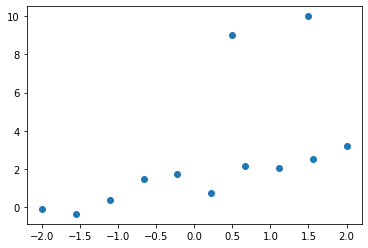

In [11]:
import math
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)
num_samples = 10

input_data = np.linspace(-2, 2, num_samples)
labels = input_data + 1 + np.random.normal(0, 0.5, size=num_samples)

input_data = np.append(input_data, [0.5, 1.5])
labels = np.append(labels, [9.0, 10.0])

plt.scatter(input_data, labels)
plt.show()

### 파라미터 계산

MLE와 MAP의 최적 파라미터는 각각 다음과 같습니다.

$$\mathbf{\theta}_{ML} = (X^\top X)^{-1}X^\top\mathbf{y} \\
\mathbf{\theta}_{MAP}=\left(X^\top X+\frac{\sigma^2}{\alpha^2}\mathbf{I}\right)^{-1}X^\top\mathbf{y}$$

노이즈 분포의 표준편차 $\sigma$는 0.1로 가정하고, 파라미터 분포의 표준편차 $\alpha$는 0.04로 지정하겠습니다. 정규화 상수 $\lambda$가 $\alpha^2$에 반비례하는 값입니다. $\alpha$가 작을수록, 즉 파라미터 분포의 표준편차를 작게 잡을수록 파라미터 값에 대한 제약 조건을 강하게 걸어주는 것과 같습니다.

정규화 측면에서 봐도 $\lambda$값이 클수록 모델의 유연성은 감소합니다.

In [12]:
def likelihood(labels, preds):
    result = 1/(np.sqrt(2*math.pi*0.1*0.1))*np.exp(-np.power(labels-preds,2)/(2*0.1*0.1))
    
    return np.prod(result)

def neg_log_likelihood(labels, preds):
    const_term = len(labels)*math.log(1/math.sqrt(2*math.pi*0.1*0.1))

    return (-1)*(const_term + 1/(2*0.1*0.1)*np.sum(-np.power(labels-preds,2)))

[MLE result] (blue)
slope: 1.4748 bias: 2.4784
likelihood: 0.0000e+00
negative log likelihood: 4.1298e+03

[MAP result] (orange)
slope: 1.1719 bias: 1.6628
likelihood: 0.0000e+00
negative log likelihood: 4.6645e+03


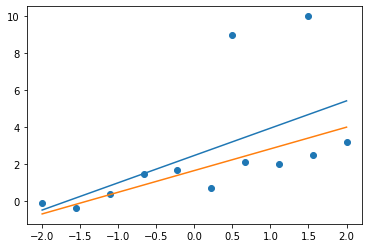

In [13]:
# X: 21x2 matrix, y: 21x1 matrix
# input_data 리스트를 column vector로 바꾼 다음 np.append 함수로 상수항을 추가합니다.
X = np.append(input_data.reshape((-1, 1)), np.ones((num_samples+2, 1)), axis=1)
y = labels

# MLE 파라미터 계산식
mle_theta_1, mle_theta_0 = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), y)
# MAP 파라미터 계산식
map_theta_1, map_theta_0 = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)+(0.1*0.1)/(0.04*0.04)*np.eye(2)), X.T), y)

print('[MLE result] (blue)')
print('slope: '+'%.4f'%mle_theta_1+' bias: '+'%.4f'%mle_theta_0)

mle_preds = mle_theta_1 * input_data + mle_theta_0
print('likelihood: '+'%.4e'%likelihood(labels, mle_preds))
print('negative log likelihood: '+'%.4e\n'%neg_log_likelihood(labels, mle_preds))

print('[MAP result] (orange)')
print('slope: '+'%.4f'%map_theta_1+' bias: '+'%.4f'%map_theta_0)

map_preds = map_theta_1 * input_data + map_theta_0
print('likelihood: '+'%.4e'%likelihood(labels, map_preds))
print('negative log likelihood: '+'%.4e'%neg_log_likelihood(labels, map_preds))

model_x = np.linspace(-2, 2, 50)
mle_model_y = mle_theta_1 * model_x + mle_theta_0
map_model_y = map_theta_1 * model_x + map_theta_0

plt.scatter(input_data, labels)
plt.plot(model_x, mle_model_y)
plt.plot(model_x, map_model_y)
plt.show()

위 그래프에서 파란색 직선과 주황색 직선은 각각 MLE, MAP를 이용해 찾은 모델을 나타냅니다.
파란색 직선은 이상치 데이터까지 포함한 negative log likelihood를 감소시키기 위해 직선이 위로 치우쳐서 아래쪽 10개 데이터의 경향성에서는 약간 벗어났습니다. 반면 주황색 직선은 이상치 데이터가 추가되어도 아래쪽 데이터에서 크게 벗어나지는 않고 있습니다.

원래 데이터 분포에서 멀리 떨어진 이상치 데이터가 추가되었기 때문에, likelihood의 값은 언더플로우가 발생해서 0으로 표시됩니다.
negative log likelihood의 값을 보면 MLE 결과와 MAP 결과를 비교할 수 있습니다. MAP가 MLE에 비해 negative log likelihood 값이 크지만(likelihood가 작지만), 이상치 데이터가 추가되었을 때 모델 파라미터의 변화는 MLE보다 작습니다.

<br/>

그럼 이것으로 오늘 내용을 마치겠습니다. :)

In [14]:
from IPython.core.display import display, HTML
display(HTML("<style> .container{width:90% !important;}</style>"))